# 1.0 Project Goal

A hypothetical record store called Chinook sells albums and or tracks to customers globally. The project goal is to analyze Chinook sales data to determine what three albums management should buy from a record label company from a list of four. All four albums are by different artists, and Chinook currently does not have their tracks in the store.

The table below shows the four artist's name and the genre of their albums:

| Artist Name | Genre |
| ----------- | ----------- |
| Regal      | Hi-Hop       |
| Red Tone   | Punk        |
| Meteor and the Girls   | Pop|
| Slim Jim Bites   | Blues |



Each customer for the Chinook store gets assigned to a sales support agent when they first make a purchase. So, this is an excellent opportunity to compare the performances of the support agents. Also, we would like to see which countries have the potential to make more sales. Using this data, in the future, we could direct our advertising campaign to focus a bit more on those countries.

# 2.0 Project Background and Database Schema

A database file with .db file extension contains sales data, customer data, employee data, and album/track data. The database schema is shown below

![Image](image/database_schema.png)

# 3.0 Importing Packages and Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
def run_query (q):
    with sqlite3.connect ('chinook.db') as conn:
        return pd.read_sql (q,conn)
    
def run_command (c):
    with sqlite3.connect ('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute (c)
def show_tables ():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view")
    '''
    return run_query (q)

In [3]:
show_tables ()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


We see the same tables we already shown using the database schema

# 4.0 Analyzing Sales Data

The record label specializes in artists from the USA and is interested in finding out which genres sell the best in the USA

Let's take a look at which genre seems to be most popular in the USA based on sales data

In [4]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
        SELECT 
            g.name genre,
            il.quantity,
            c.country
        FROM genre g
        LEFT JOIN track t ON t.genre_id = g.genre_id
        LEFT JOIN invoice_line il ON il.track_id = t.track_id
        LEFT JOIN invoice i ON il.invoice_id = i.invoice_id
        LEFT JOIN customer c on c.customer_id = i.customer_id
        WHERE country = "USA"
    )
SELECT 
    genre,
    cast (SUM (quantity) as int) tracks_sold,
    cast (SUM (quantity) as float)/ (
        SELECT SUM (quantity) FROM usa_tracks_sold) percentage
FROM usa_tracks_sold
GROUP BY 1
HAVING tracks_sold IS NOT NULL
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


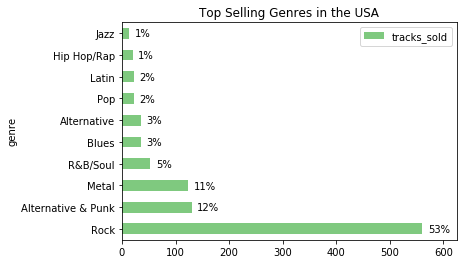

In [5]:
genre_sales_usa = run_query (albums_to_purchase)

genre_sales_usa.plot (
    x = "genre", y = "tracks_sold", kind = "barh",
    title = "Top Selling Genres in the USA",
    xlim = (0,625),
    colormap = plt.cm.Accent
    )

#Annotate using percentages
for i,label in enumerate (list (genre_sales_usa.index)):
    score = genre_sales_usa.loc [label,"tracks_sold"]
    label = (genre_sales_usa.loc [label,"percentage"]*100
            ).astype (int).astype (str) + "%"
    plt.annotate(str(label), (score + 10, i-0.15), clip_on = True)
plt.show ()

Bases on the sales data, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues), and
- Meteor and the Girls (Pop)

# 5.0 Purchasing Albums vs. Individual Tracks

The Chinook record store allows customers to purchase a whole album or purchase one or more individual tracks. The store does not let customers buy an entire album and then add individual tracks to that same purchase (unless they do that by choosing each track manually).  There is no cost difference between purchasing the full album vs. purchasing the tracks individually.

The management team is considering buying only the most popular tracks from the albums to save money. So, let's look at what percentages of purchases are individual tracks vs. the whole album. We can then use this data to understand the effect this decision might have on overall revenue

In [6]:
album_track_classification = '''
    WITH
        invoice_info AS
        (
            SELECT
                 i.invoice_id,
                 il.track_id
            FROM invoice i
            LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id
        ),
        
        album_track AS
        (
            SELECT 
                 a.album_id,
                 a.title,
                 t.track_id
            FROM album a
            LEFT JOIN track t ON t.album_id = a.album_id
        ),
        album_vs_track AS
        (
            SELECT
                ii.invoice_id,
                ii.track_id,
                at.album_id,
                at.title album_name,
                at.track_id,
                CASE
                    WHEN (
                            (
                            SELECT
                                ii2.track_id
                            FROM invoice_info ii2
                            WHERE ii2.invoice_id = ii.invoice_id

                            EXCEPT

                            SELECT
                                at2.track_id
                            FROM album_track at2
                            WHERE at2.album_id = at.album_id
                            ) IS NULL


                            AND

                            (
                            SELECT
                                at2.track_id
                            FROM album_track at2
                            WHERE at2.album_id = at.album_id

                            EXCEPT

                            SELECT
                                ii2.track_id
                            FROM invoice_info ii2
                            WHERE ii2.invoice_id = ii.invoice_id
                            ) IS NULL                    
                        ) 
                        THEN "Yes"
                        ELSE "No"
                    END AS album_purchase
            FROM invoice_info ii
            INNER JOIN album_track at ON at.track_id = ii.track_id     
        )
    SELECT
        album_purchase,
        COUNT (DISTINCT invoice_id) number_of_invoices,
        CAST (COUNT (DISTINCT invoice_id) AS FLOAT)/ (
                                        SELECT COUNT (*) FROM invoice
                                     ) percent
    FROM album_vs_track
    GROUP BY album_purchase;          
'''
run_query(album_track_classification)

,album_purchase,number_of_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


Album purchases account for 18.6% of purchases. So, it would be unwise to buy invidiual tracks only as there is a potential to lose about 1/5th the revneue.

# 6.0 Analyzing Sales by Country

Let's next take a look at sales data by country

In [7]:
sales_country = '''
    WITH 
        country_or_other AS
            (
                SELECT 
                    c.country,
                    c.customer_id,
                    i.invoice_id,
                    i.total,
                CASE
                    WHEN (
                            SELECT count (DISTINCT customer_id)
                            FROM customer
                            WHERE country = c.country
                         ) = 1 THEN "Other"
                    ELSE c.country
                END AS country_m
                FROM customer c
                INNER JOIN invoice i ON i.customer_id = c.customer_id
            ),
        country_sales_data AS
            (
                SELECT
                    coo.country_m country,
                    COUNT (DISTINCT coo.customer_id) customers,
                    SUM (coo.total) total_sales,
                    SUM (coo.total)/ COUNT (DISTINCT invoice_id) average_order,
                    SUM (coo.total)/ COUNT (DISTINCT coo.customer_id) customer_lifetime_value,
                    CASE
                        WHEN coo.country_m = "Other" THEN 1
                        ELSE 0
                    END AS sort
                FROM country_or_other coo  
                GROUP BY 1
                ORDER BY sort ASC, total_sales DESC
            )

SELECT 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM country_sales_data
'''
run_query (sales_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


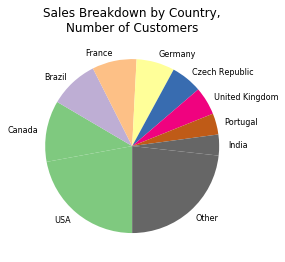

In [8]:
#Data cleanup for pie chart
country_metrics = run_query(sales_country )
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent (i) for i in np.linspace (0,1,country_metrics.shape[0])]

#pie chart
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':3}
    
)

The USA has had more sales compared to other countries. However, the USA also has the most customers. Let's look at sales per customer to see if other countries could be more profitable if we started selling more there.

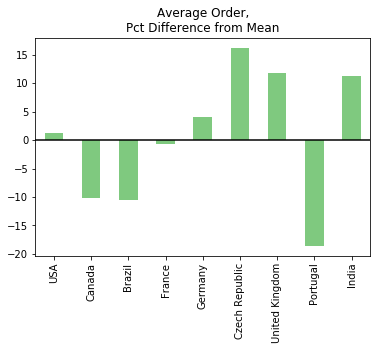

In [9]:
#Bar plot for differences from mean
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    color=colors[0],
    title="Average Order,\nPct Difference from Mean"
)
plt.axhline (0, color='k')

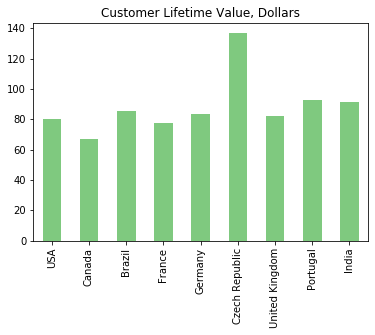

In [10]:
# Lifetime value of customers
lifetime_value = country_metrics["customer_lifetime_value"].copy()
lifetime_value.index.name = ''
lifetime_value.drop("Other",inplace=True)
lifetime_value.plot.bar(
    color=colors[0],
    title="Customer Lifetime Value, Dollars"
)

We see that on average, customers from the Czech Republic, United Kingdom, and India order more. Customers from these countries also have competitive lifetime value in dollars. So, we should focus on advertising in those countries to sell more. The sample size is small here, so we can't put too much trust into these numbers. As a result, we need to be careful not to spend too much on advertising in those countries. 

# 7.0 Conclusion

This project looked at existing sales data of Chinook record store in the USA to determine which three albums it should buy. It should purchase albums from the following artists: Red Tone (Genre: Punk), Slim Jim Bites (Genre: Blues), and Meteor and the Girls (Genre: Pop).

The USA is by far is the best-performing country in terms of sales. However, the Czech Republic, the United Kingdom, and India could be three countries where we could try selling more as customers from those countries seem to buy more on average and have higher lifetime value in dollars.